# Data Augmentation Analysis for Bruise Detection

This notebook compares different data augmentation strategies:
1. Baseline (no augmentation)
2. Horizontal flip only
3. Rotation only (±20 degrees)
4. Zoom only (±20%)
5. All augmentations combined

We'll use the same model architecture and preprocessing from the main CNN notebook.

In [10]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import pandas as pd

In [11]:
def load_binary_data(data_dir='dataset/Wound_dataset copy', img_size=(224, 224)):
    images = []
    labels = []
    
    # Check if directory exists
    if not os.path.exists(data_dir):
        raise ValueError(f"Dataset directory not found: {data_dir}")
    
    # Process bruise images (positive class)
    bruise_path = os.path.join(data_dir, 'Bruises')
    if not os.path.exists(bruise_path):
        raise ValueError(f"Bruises directory not found: {bruise_path}")
    
    for img_name in os.listdir(bruise_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(bruise_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                labels.append(1)  # 1 for bruise
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    # Process normal skin images (negative class)
    normal_path = os.path.join(data_dir, 'Normal')
    if not os.path.exists(normal_path):
        raise ValueError(f"Normal directory not found: {normal_path}")
    
    for img_name in os.listdir(normal_path):
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(normal_path, img_name)
            try:
                img = Image.open(img_path)
                img = img.convert('RGB')
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0
                
                images.append(img_array)
                labels.append(0)  # 0 for normal
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    if not images:
        raise ValueError("No images were loaded. Check the dataset structure and file formats.")
    
    return np.array(images), np.array(labels)

# Try loading the dataset with explicit error handling
try:
    print("Attempting to load dataset...")
    print("Current working directory:", os.getcwd())
    X, y = load_binary_data()
    print("Dataset shape:", X.shape)
    print("Number of bruise images:", np.sum(y == 1))
    print("Number of normal images:", np.sum(y == 0))
except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Please verify the dataset path and structure.")

Attempting to load dataset...
Current working directory: C:\Users\Rodney Lei Estrada\xcode\bruise_detection_project
Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200
Dataset shape: (442, 224, 224, 3)
Number of bruise images: 242
Number of normal images: 200


## Model Architecture and Training Functions

We'll use the same CNN architecture as the main notebook, but train it with different augmentation strategies.

In [12]:
def create_model(input_shape):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),
        
        # Simple CNN architecture
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        # Flatten layer
        layers.Flatten(),
        
        # Dense layer
        layers.Dense(64, activation='relu'),
        
        # Output layer (binary classification)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

def train_model_with_augmentation(X_train, y_train, X_val, y_val, augmentation_config=None, model_name="baseline"):
    # Create data generator with augmentation
    if augmentation_config is not None:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            **augmentation_config
        )
    else:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    
    # Create and compile model
    input_shape = X_train[0].shape
    model = create_model(input_shape)
    
    # Define custom metrics
    precision_metric = tf.keras.metrics.Precision(name='precision')
    recall_metric = tf.keras.metrics.Recall(name='recall')
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', precision_metric, recall_metric]
    )
    
    # Train the model with custom callbacks
    history = model.fit(
        train_datagen.flow(X_train, y_train, batch_size=32),
        epochs=10,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True
            )
        ],
        verbose=1
    )
    
    return model, history

# Define augmentation configurations
augmentation_configs = {
    'baseline': None,
    'flip': {'horizontal_flip': True},
    'rotation': {'rotation_range': 20},
    'zoom': {'zoom_range': 0.2},
    'all': {
        'horizontal_flip': True,
        'rotation_range': 10,  # Reduced from 20
        'zoom_range': 0.1     # Reduced from 0.2
    }
}

# Split data only if X and y are not empty
if X.size == 0 or y.size == 0:
    print("Warning: X and/or y are empty. Please check your dataset loading step.")
    X_train = X_val = X_test = y_train = y_val = y_test = np.array([])
else:
    # First split off test set (10%)
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    # Split remaining 90% into train (70%) and validation (20%)
    X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.20, random_state=42)

    print("\nData split sizes:")
    print(f"Training set: {len(X_train)} images ({len(X_train)/len(X)*100:.1f}%)")
    print(f"Validation set: {len(X_val)} images ({len(X_val)/len(X)*100:.1f}%)")
    print(f"Test set: {len(X_test)} images ({len(X_test)/len(X)*100:.1f}%)")


Data split sizes:
Training set: 317 images (71.7%)
Validation set: 80 images (18.1%)
Test set: 45 images (10.2%)


## Train Models with Different Augmentation Strategies

We'll train 5 different models and compare their performance:

In [13]:
# Dictionary to store results
results = {}

# Train models with different augmentation strategies
for aug_name, aug_config in augmentation_configs.items():
    print(f"\nTraining model with {aug_name} augmentation...")
    model, history = train_model_with_augmentation(
        X_train, y_train,
        X_val, y_val,
        augmentation_config=aug_config,
        model_name=aug_name
    )
    
    # Evaluate on test set
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
    
    # Get predictions for ROC curve
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Store results including the model
    results[aug_name] = {
        'model': model,  # Store the model object
        'history': history.history,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }
    
    print(f"\nTest Results for {aug_name}:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))


Training model with baseline augmentation...


C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6094 - loss: 8.5790 - precision: 0.6546 - recall: 0.6798 - val_accuracy: 0.5500 - val_loss: 0.6854 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.6094 - loss: 8.5790 - precision: 0.6546 - recall: 0.6798 - val_accuracy: 0.5500 - val_loss: 0.6854 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5264 - loss: 0.7153 - precision: 0.5281 - recall: 0.9573 - val_accuracy: 0.5750 - val_loss: 0.6304 - val_precision: 0.5641 - val_recall: 1.0000
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5264 - loss: 0.7153 - precision: 0.5281 - recall: 0.9573 - val_accuracy: 0.5750 - val_loss: 0.6304 - val_precision: 0.5641 - val_recall: 1.0000
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6910 - loss: 0.6278 - precision: 0.6651 - recall: 0.8894 - val_accuracy: 0.5500 - val_loss: 0.6723 - val

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5748 - loss: 4.8571 - precision: 0.5760 - recall: 0.7349 - val_accuracy: 0.7000 - val_loss: 1.3891 - val_precision: 1.0000 - val_recall: 0.4545
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5748 - loss: 4.8571 - precision: 0.5760 - recall: 0.7349 - val_accuracy: 0.7000 - val_loss: 1.3891 - val_precision: 1.0000 - val_recall: 0.4545
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7920 - loss: 0.7669 - precision: 0.8952 - recall: 0.7202 - val_accuracy: 0.8500 - val_loss: 0.3888 - val_precision: 0.8333 - val_recall: 0.9091
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.7920 - loss: 0.7669 - precision: 0.8952 - recall: 0.7202 - val_accuracy: 0.8500 - val_loss: 0.3888 - val_precision: 0.8333 - val_recall: 0.9091
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.9036 - loss: 0.3814 - precision: 0.8937 - recall: 0.9467 - val_accuracy: 0.9000 - val_loss: 0.2350 - val_precision:

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4846 - loss: 9.2184 - precision: 0.5259 - recall: 0.6455 - val_accuracy: 0.8750 - val_loss: 0.3823 - val_precision: 0.9250 - val_recall: 0.8409
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4846 - loss: 9.2184 - precision: 0.5259 - recall: 0.6455 - val_accuracy: 0.8750 - val_loss: 0.3823 - val_precision: 0.9250 - val_recall: 0.8409
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8077 - loss: 0.9627 - precision: 0.8707 - recall: 0.7786 - val_accuracy: 0.7625 - val_loss: 1.0028 - val_precision: 0.9630 - val_recall: 0.5909
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8077 - loss: 0.9627 - precision: 0.8707 - recall: 0.7786 - val_accuracy: 0.7625 - val_loss: 1.0028 - val_precision: 0.9630 - val_recall: 0.5909
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8593 - loss: 0.3906 - precision: 0.8872 - recall: 0.8457 - val_accuracy: 0.8000 - val_loss: 0.4170 - val

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5687 - loss: 12.5743 - precision: 0.6018 - recall: 0.8313 - val_accuracy: 0.5500 - val_loss: 1.0473 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5687 - loss: 12.5743 - precision: 0.6018 - recall: 0.8313 - val_accuracy: 0.5500 - val_loss: 1.0473 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4980 - loss: 0.8750 - precision: 0.5168 - recall: 0.5568 - val_accuracy: 0.4500 - val_loss: 0.6936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4980 - loss: 0.8750 - precision: 0.5168 - recall: 0.5568 - val_accuracy: 0.4500 - val_loss: 0.6936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.4255 - loss: 0.6938 - precision: 0.4545 - recall: 0.0030 - val_accuracy: 0.4500 - val_

C:\Users\Rodney Lei Estrada\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5426 - loss: 15.2217 - precision: 0.4295 - recall: 0.4228 - val_accuracy: 0.5500 - val_loss: 4.1634 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5426 - loss: 15.2217 - precision: 0.4295 - recall: 0.4228 - val_accuracy: 0.5500 - val_loss: 4.1634 - val_precision: 0.5500 - val_recall: 1.0000
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5338 - loss: 1.8564 - precision: 0.5749 - recall: 0.6308 - val_accuracy: 0.4500 - val_loss: 0.6935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.5338 - loss: 1.8564 - precision: 0.5749 - recall: 0.6308 - val_accuracy: 0.4500 - val_loss: 0.6935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.4197 - loss: 0.6937 - precision: 0.1897 - recall: 0.0640 - val_accuracy: 0.4500 - val_

## Visualization and Analysis


Performance Summary:
Augmentation Accuracy Precision Recall ROC AUC
    baseline   0.8667    0.8750 0.8750  0.8919
        flip   0.9111    0.9167 0.9167  0.9762
    rotation   0.9111    0.8846 0.9583  0.9762
        zoom   0.8000    0.8571 0.7500  0.8175
         all   0.5333    0.5333 1.0000  0.5000


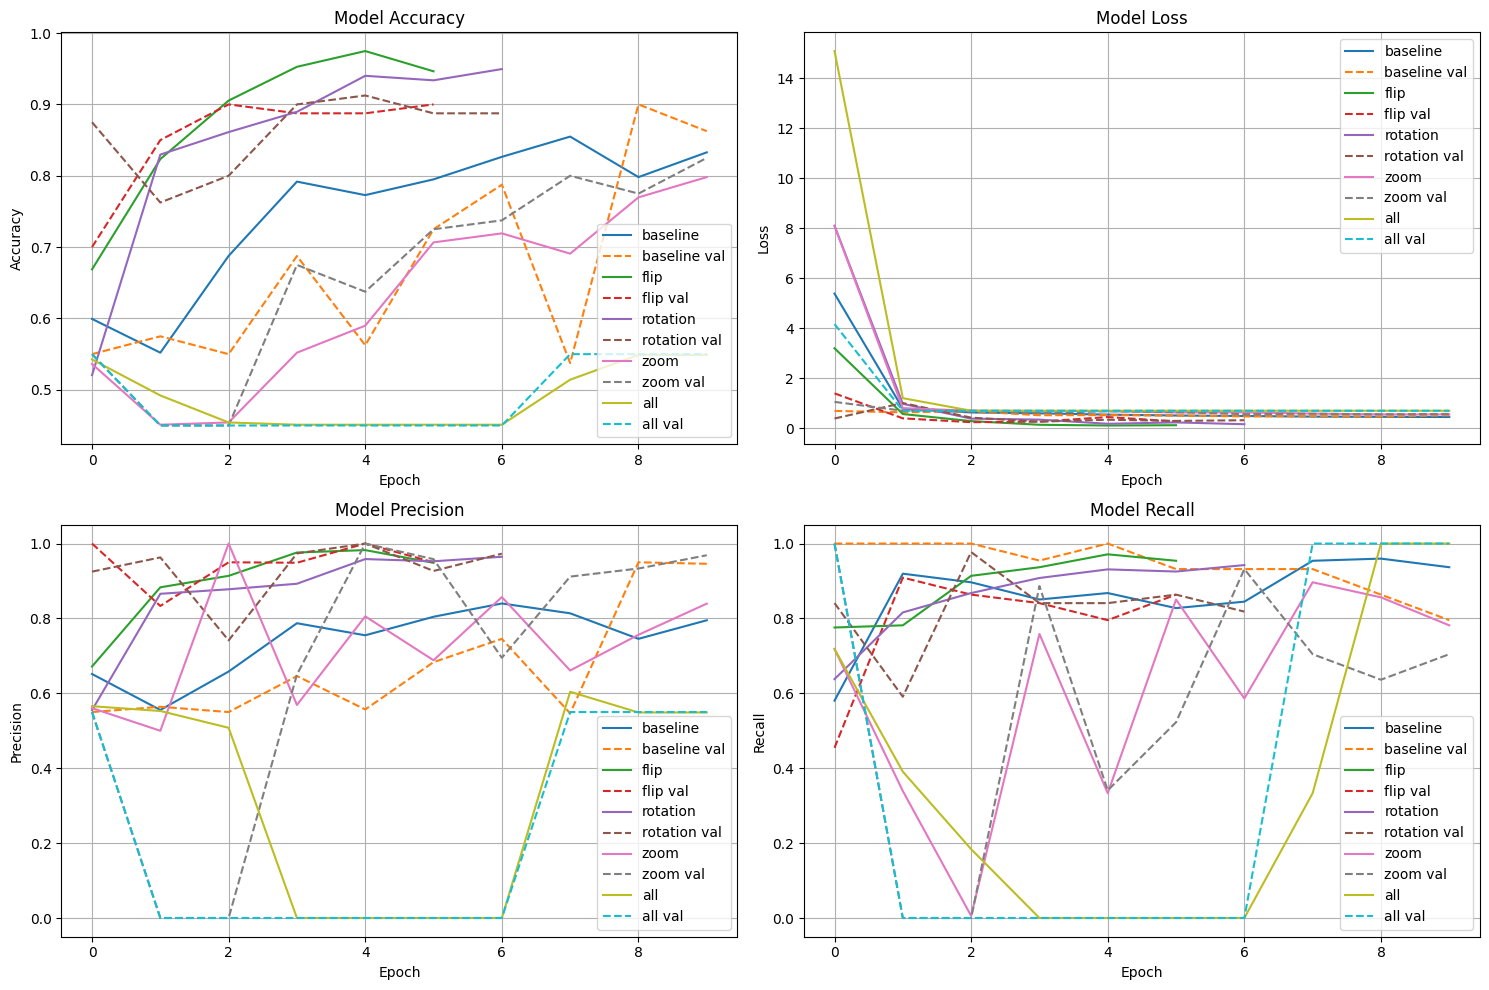

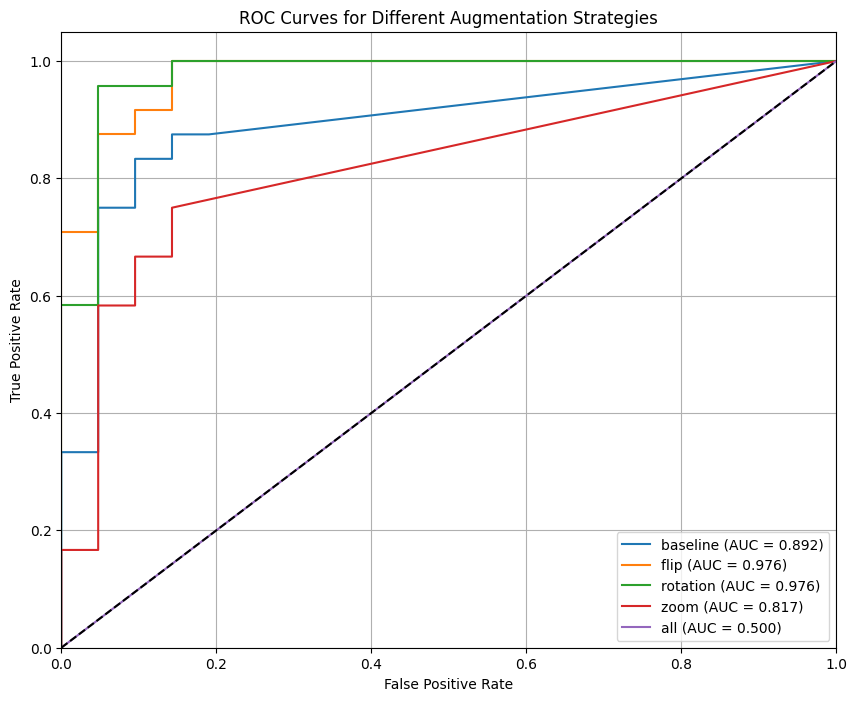

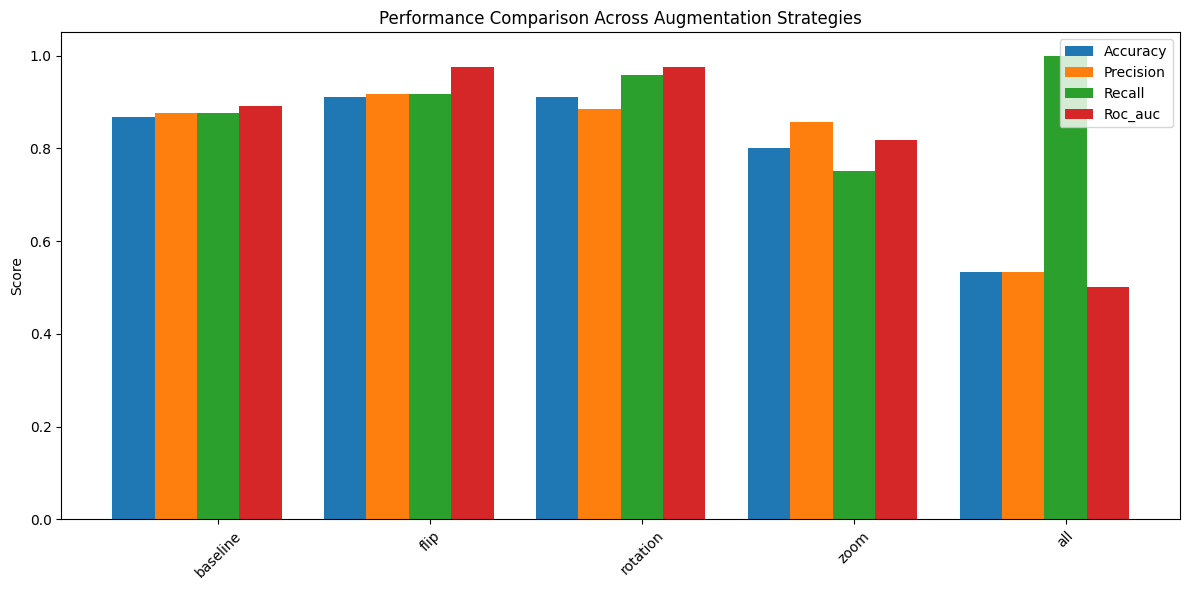

In [14]:
def plot_training_histories(results):
    plt.figure(figsize=(15, 10))
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        has_data = False
        
        for aug_name in results.keys():
            history = results[aug_name]['history']
            if metric in history:
                values = history[metric]
                line, = plt.plot(values, label=f'{aug_name}')
                has_data = True
                if f'val_{metric}' in history:
                    val_values = history[f'val_{metric}']
                    plt.plot(val_values, '--', label=f'{aug_name} val')
        
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        if has_data:
            plt.legend(loc='best')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(results):
    plt.figure(figsize=(10, 8))
    
    for aug_name in results.keys():
        result = results[aug_name]
        if 'fpr' in result and 'tpr' in result:
            fpr = result['fpr']
            tpr = result['tpr']
            roc_auc = result.get('roc_auc', 0)
            plt.plot(fpr, tpr, label=f'{aug_name} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Augmentation Strategies')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_performance_comparison(results):
    metrics = ['test_accuracy', 'test_precision', 'test_recall', 'roc_auc']
    labels = [m.replace('test_', '').capitalize() for m in metrics]
    x = np.arange(len(results))
    width = 0.8 / len(metrics)  # Adjusted width
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    for i, (metric, label) in enumerate(zip(metrics, labels)):
        values = []
        for aug_name in results.keys():
            value = results[aug_name].get(metric, 0)
            value = 0 if np.isnan(value) else value
            values.append(value)
        ax.bar(x + i*width - width*len(metrics)/2, values, width, label=label)
    
    ax.set_ylabel('Score')
    ax.set_title('Performance Comparison Across Augmentation Strategies')
    ax.set_xticks(x)
    ax.set_xticklabels(list(results.keys()), rotation=45)
    ax.legend()
    plt.tight_layout()
    plt.show()

def analyze_results(results):
    summary_data = {
        'Augmentation': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'ROC AUC': []
    }

    for aug_name, result in results.items():
        summary_data['Augmentation'].append(aug_name)
        summary_data['Accuracy'].append(f"{result.get('test_accuracy', 0):.4f}")
        summary_data['Precision'].append(f"{result.get('test_precision', 0):.4f}")
        summary_data['Recall'].append(f"{result.get('test_recall', 0):.4f}")
        summary_data['ROC AUC'].append(f"{result.get('roc_auc', 0):.4f}")

    summary_df = pd.DataFrame(summary_data)
    print("\nPerformance Summary:")
    print(summary_df.to_string(index=False))
    
    # Plot the comparisons
    plot_training_histories(results)
    plot_roc_curves(results)
    plot_performance_comparison(results)

# Analyze and visualize the results
analyze_results(results)

## Detailed Metrics Comparison

Let's analyze the performance metrics in tabular format:

Performance Metrics:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,baseline,86.67%,87.50%,87.50%,87.50%,89.19%
1,flip,91.11%,91.67%,91.67%,91.67%,97.62%
2,rotation,91.11%,88.46%,95.83%,92.00%,97.62%
3,zoom,80.00%,85.71%,75.00%,80.00%,81.75%
4,all,53.33%,53.33%,100.00%,69.57%,50.00%


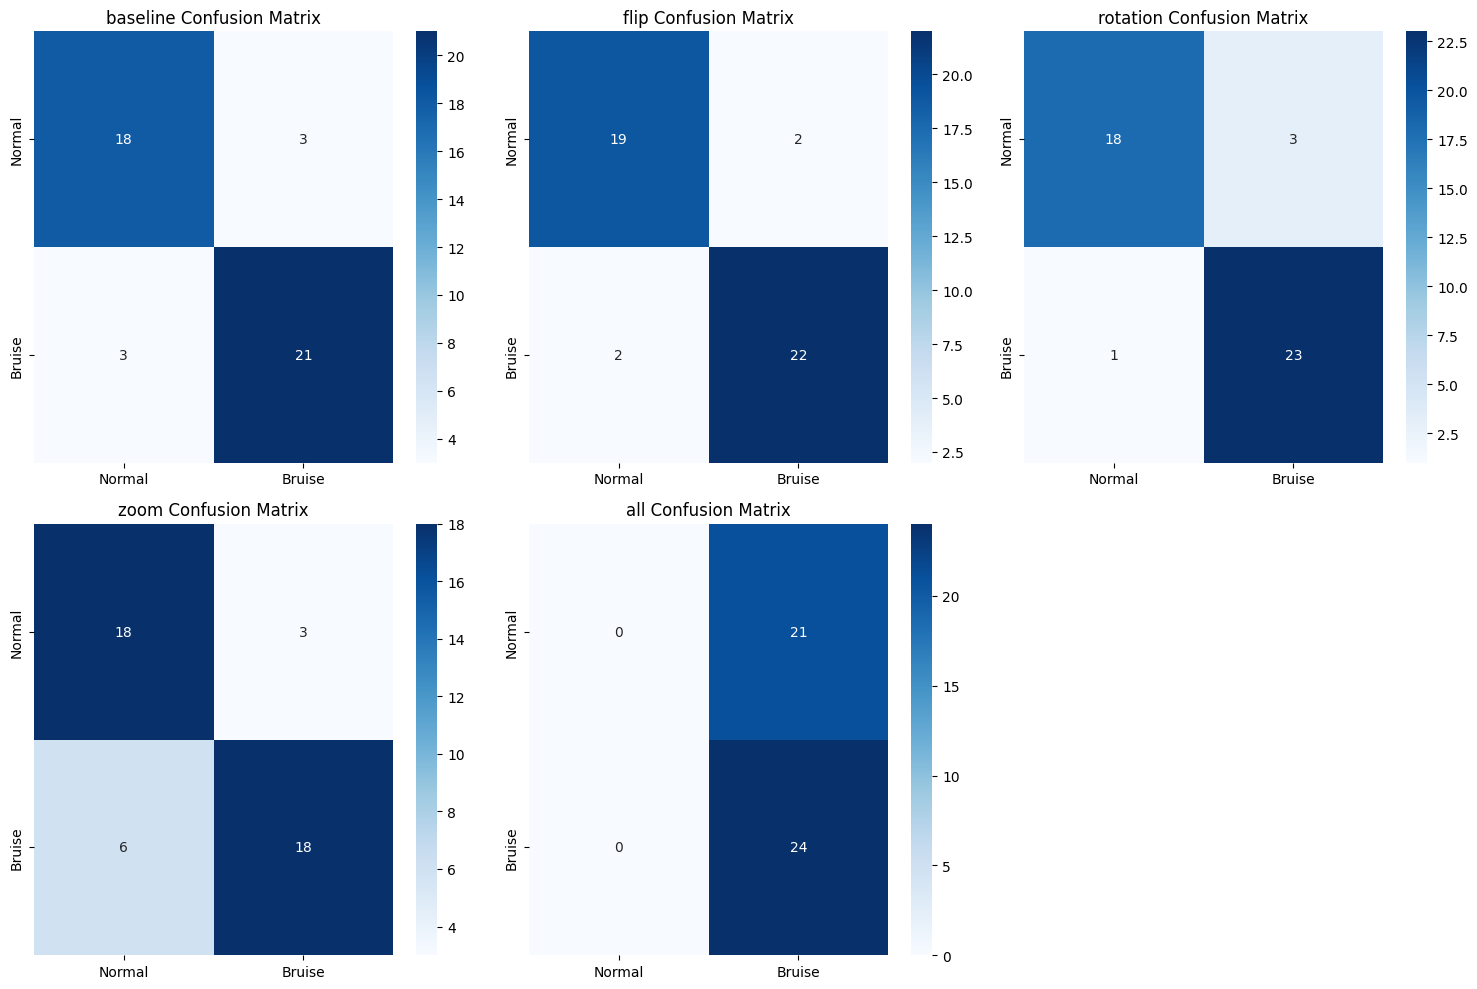

In [15]:
def create_metrics_tables_and_plots(results):
    # Create detailed metrics dataframe
    metrics_data = []
    
    for model_name in results.keys():
        result = results[model_name]
        precision = result.get('test_precision', 0)
        recall = result.get('test_recall', 0)
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        metrics_data.append({
            'Model': model_name,
            'Accuracy': result.get('test_accuracy', 0),
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1_score,
            'ROC AUC': result.get('roc_auc', 0)
        })
    
    metrics_df = pd.DataFrame(metrics_data)
    
    # Format percentages
    for col in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']:
        metrics_df[col] = metrics_df[col].apply(lambda x: f"{x*100:.2f}%")
    
    # Print metrics table
    print("Performance Metrics:")
    display(metrics_df)
    
    # Plot confusion matrices
    n_models = len(results)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (model_name, result) in enumerate(results.items()):
        if idx < len(axes) and 'confusion_matrix' in result:
            sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Normal', 'Bruise'],
                       yticklabels=['Normal', 'Bruise'],
                       ax=axes[idx])
            axes[idx].set_title(f'{model_name} Confusion Matrix')
    
    # Remove empty subplots
    for idx in range(n_models, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()

# Generate the detailed analysis
create_metrics_tables_and_plots(results)